# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Litecoin cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
start = "1514761200" # 01.01.2018
periods = 86 # approx 8 years
TICKER = "LTCUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR="LTCUSDT:high"
TIME = "LTCUSDT:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2017-12-31 23:00:00,226.44000000,227.22000000,222.53000000,223.69000000,1157.31361000
1,2018-01-01 00:00:00,223.69000000,223.69000000,217.25000000,219.98000000,978.11778000
2,2018-01-01 01:00:00,219.25000000,220.50000000,212.74000000,212.75000000,1165.80333000
3,2018-01-01 02:00:00,212.75000000,216.99000000,212.75000000,216.32000000,736.41344000
4,2018-01-01 03:00:00,215.71000000,220.99000000,215.20000000,218.12000000,1005.10601000
...,...,...,...,...,...,...
61816,2025-01-23 18:00:00,116.13000000,116.34000000,114.41000000,114.49000000,13404.75600000
61817,2025-01-23 19:00:00,114.49000000,114.60000000,113.11000000,113.81000000,23190.04100000
61818,2025-01-23 20:00:00,113.80000000,116.79000000,113.57000000,115.69000000,81136.96600000
61819,2025-01-23 21:00:00,115.69000000,115.97000000,113.08000000,113.73000000,29473.79700000


In [ ]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

In [ ]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data["LTCUSDT:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data["LTCUSDT:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

In [4]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:volume0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:volume1,LTCUSDT:high2,...,LTCUSDT:volume2,LTCUSDT:high3,LTCUSDT:low3,LTCUSDT:close3,LTCUSDT:volume3,LTCUSDT:high4,LTCUSDT:low4,LTCUSDT:close4,LTCUSDT:volume4,Label
0,2018-01-01 04:00:00,0.000000,-2.878984,-1.658545,-15.483775,0.570125,-2.969213,-2.964652,19.188441,1.992949,...,-36.832104,2.447731,-0.236429,1.117241,36.486647,2.911242,0.000000,2.672841,-13.130611,1
1,2018-01-01 05:00:00,0.570125,-2.969213,-2.964652,19.188441,1.992949,0.000000,1.678026,-36.832104,2.447731,...,36.486647,2.911242,0.000000,2.672841,-13.130611,0.723343,-0.549205,0.107162,-31.348340,1
2,2018-01-01 06:00:00,1.992949,0.000000,1.678026,-36.832104,2.447731,-0.236429,1.117241,36.486647,2.911242,...,-13.130611,0.723343,-0.549205,0.107162,-31.348340,2.952984,-0.388081,2.551521,58.440409,0
3,2018-01-01 07:00:00,2.447731,-0.236429,1.117241,36.486647,2.911242,0.000000,2.672841,-13.130611,0.723343,...,-31.348340,2.952984,-0.388081,2.551521,58.440409,0.039146,-2.222609,-2.096473,-29.899582,1
4,2018-01-01 08:00:00,2.911242,0.000000,2.672841,-13.130611,0.723343,-0.549205,0.107162,-31.348340,2.952984,...,58.440409,0.039146,-2.222609,-2.096473,-29.899582,0.830631,-0.946120,-0.279838,51.699673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61810,2025-01-23 17:00:00,1.716278,-0.035756,1.430232,84.565993,2.229861,-0.520007,1.912568,116.386575,0.977255,...,28.908969,1.077958,-0.560538,0.172473,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0
61811,2025-01-23 18:00:00,2.229861,-0.520007,1.912568,116.386575,0.977255,-1.461558,0.285393,28.908969,1.077958,...,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0.180832,-1.481099,-1.412210,-38.167640,0
61812,2025-01-23 19:00:00,0.977255,-1.461558,0.285393,28.908969,1.077958,-0.560538,0.172473,-27.702915,0.137753,...,-55.414521,0.180832,-1.481099,-1.412210,-38.167640,0.096078,-1.205345,-0.593938,72.998606,1
61813,2025-01-23 20:00:00,1.077958,-0.560538,0.172473,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0.180832,...,-38.167640,0.096078,-1.205345,-0.593938,72.998606,2.627417,-0.202109,1.660808,249.878493,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [5]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = ["LTCUSDT:high0", "LTCUSDT:low0", "LTCUSDT:close0", "LTCUSDT:volume0", "LTCUSDT:high1", "LTCUSDT:low1", "LTCUSDT:close1", "LTCUSDT:volume1", "LTCUSDT:high2", "LTCUSDT:low2", "LTCUSDT:close2", "LTCUSDT:volume2", "LTCUSDT:high3", "LTCUSDT:low3", "LTCUSDT:close3", "LTCUSDT:volume3", "LTCUSDT:high4", "LTCUSDT:low4", "LTCUSDT:close4", "LTCUSDT:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250217_114909"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       7.33 GB / 15.92 GB (46.0%)
Disk Space Avail:   151.64 GB / 475.69 GB (31.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [6]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


51815    0
51816    0
51817    0
51818    0
51819    0
        ..
61810    1
61811    1
61812    1
61813    1
61814    1
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.702,
 'balanced_accuracy': 0.6517640677248537,
 'mcc': 0.3239770795265238,
 'roc_auc': 0.7245128757542677,
 'f1': 0.5329153605015674,
 'precision': 0.6067094932191291,
 'recall': 0.47512576858580213,
 'confusion_matrix':       0     1
 0  5320  1102
 1  1878  1700,
 'classification_report': {'0': {'precision': 0.739094192831342,
   'recall': 0.8284023668639053,
   'f1-score': 0.7812041116005873,
   'support': 6422.0},
  '1': {'precision': 0.6067094932191291,
   'recall': 0.47512576858580213,
   'f1-score': 0.5329153605015674,
   'support': 3578.0},
  'accuracy': 0.702,
  'macro avg': {'precision': 0.6729018430252356,
   'recall': 0.6517640677248537,
   'f1-score': 0.6570597360510774,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6917269473100922,
   'recall': 0.702,
   'f1-score': 0.6923663964573581,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	10.04s	= Expected runtime (2.01s per shuffle set)
	6.63s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
LTCUSDT:high4,0.03836,0.005516,0.000050,5,0.049718,0.027002
LTCUSDT:close4,0.02936,0.005341,0.000126,5,0.040358,0.018362
LTCUSDT:high3,0.00840,0.002280,0.000592,5,0.013095,0.003705
LTCUSDT:low4,0.00764,0.003204,0.002980,5,0.014238,0.001042
LTCUSDT:high2,0.00424,0.002578,0.010629,5,0.009549,-0.001069
LTCUSDT:low2,0.00364,0.001987,0.007449,5,0.007731,-0.000451
LTCUSDT:close3,0.00232,0.001339,0.008956,5,0.005076,-0.000436
LTCUSDT:high0,0.00212,0.001418,0.014391,5,0.005041,-0.000801
LTCUSDT:close0,0.00192,0.002239,0.063804,5,0.006530,-0.002690
LTCUSDT:high1,0.00160,0.001311,0.026276,5,0.004300,-0.001100


In [7]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.695221,0.304779
1,0.580657,0.419343
2,0.638473,0.361527
3,0.533740,0.466260
4,0.506748,0.493252
...,...,...
9995,0.497927,0.502073
9996,0.266963,0.733037
9997,0.328249,0.671751
9998,0.385451,0.614549


,Label
0,0
1,0
2,0
3,0
4,0
...,...
9995,1
9996,1
9997,1
9998,1


,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:volume0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:volume1,LTCUSDT:high2,LTCUSDT:low2,...,LTCUSDT:volume2,LTCUSDT:high3,LTCUSDT:low3,LTCUSDT:close3,LTCUSDT:volume3,LTCUSDT:high4,LTCUSDT:low4,LTCUSDT:close4,LTCUSDT:volume4,Label
0,0.311780,-0.176223,-0.067778,-49.313234,1.343101,0.000000,0.230634,-12.684669,0.365408,-0.162404,...,-7.321397,0.405022,-0.405022,-0.135007,105.501261,0.432666,-0.162250,-0.162250,-51.833135,0
1,1.343101,0.000000,0.230634,-12.684669,0.365408,-0.162404,0.216538,-7.321397,0.405022,-0.405022,...,105.501261,0.432666,-0.162250,-0.162250,-51.833135,0.352113,-0.541712,-0.379198,2.106865,1
2,0.365408,-0.162404,0.216538,-7.321397,0.405022,-0.405022,-0.135007,105.501261,0.432666,-0.162250,...,-51.833135,0.352113,-0.541712,-0.379198,2.106865,0.856444,-0.122349,0.706906,-25.906102,1
3,0.405022,-0.405022,-0.135007,105.501261,0.432666,-0.162250,-0.162250,-51.833135,0.352113,-0.541712,...,2.106865,0.856444,-0.122349,0.706906,-25.906102,1.322716,-0.350925,0.107977,291.839986,1
4,0.432666,-0.162250,-0.162250,-51.833135,0.352113,-0.541712,-0.379198,2.106865,0.856444,-0.122349,...,-25.906102,1.322716,-0.350925,0.107977,291.839986,1.105568,0.000000,0.660644,-52.000570,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.716278,-0.035756,1.430232,84.565993,2.229861,-0.520007,1.912568,116.386575,0.977255,-1.461558,...,28.908969,1.077958,-0.560538,0.172473,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0
9996,2.229861,-0.520007,1.912568,116.386575,0.977255,-1.461558,0.285393,28.908969,1.077958,-0.560538,...,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0.180832,-1.481099,-1.412210,-38.167640,0
9997,0.977255,-1.461558,0.285393,28.908969,1.077958,-0.560538,0.172473,-27.702915,0.137753,-1.325872,...,-55.414521,0.180832,-1.481099,-1.412210,-38.167640,0.096078,-1.205345,-0.593938,72.998606,1
9998,1.077958,-0.560538,0.172473,-27.702915,0.137753,-1.325872,-0.025829,-55.414521,0.180832,-1.481099,...,-38.167640,0.096078,-1.205345,-0.593938,72.998606,2.627417,-0.202109,1.660808,249.878493,0


MEAN PROB 1 CLASSIFICATION: 0.40707814310193063
MAX PROB 1 CLASSIFICATION: 0.9750062227249146
MIN PROB 1 CLASSIFICATION: 0.08293652534484863
COUNT OF NUMBERS > 0.7: 544
COUNT OF NUMBERS > 0.8: 142
COUNT OF NUMBERS > 0.9: 14


CORRECT: 431
WRONG: 113
NUMBER OF TRADES: 544
WIN RATE: 79.23%
RETURN: 69.72
INVESTMENT VALUE: 169.72
MEAN RETURN: 0.0055820517893984236
ST_DEV: 0.23895277852779004
SHARP RATIO: 2.3360480776954997
MEAN RETURN: 0.008138986391337737
ST_DEV: 0.866366762821512
SHARP RATIO ONLY HOLDING ASSET: 0.939438900545002
MEAN RETURN BAD TRADES: -1.413070796460177
----------------------------------
-1.476
-0.84
-0.648
-1.001
-0.615
-0.581
-1.079
-2.085
-0.839
0.012
-8.892
-1.493
-0.787
-2.352
-3.073
0.037
-1.317
-0.874
0.025
-1.328
-1.149
-0.284
-0.18
-0.757
0.162
-2.07
-2.316
-0.871
0.31
-0.371
-2.949
0.338
-1.823
-0.621
-0.314
-3.516
-0.602
-1.959
0.298
-5.459
-3.247
-0.805
-0.045
0.293
0.198
-0.395
-2.421
-1.483
-2.064
-1.924
-0.405
-0.676
0.0
-2.335
-1.742
-0.334
-0.12
-0.022
-1.898
-0.284
-3.293
-0.879
0.311
0.0
-0.745
-2.651
-3.858
-1.112
-0.528
-1.694
-2.581
-2.81
-2.225
-1.593
-0.5
-0.928
-5.02
-5.064
-2.159
-0.426
-1.246
-0.816
-0.729
-1.091
-1.839
-3.747
-2.2
-0.569
0.3
-1.965
-4.73
-0.526
-1

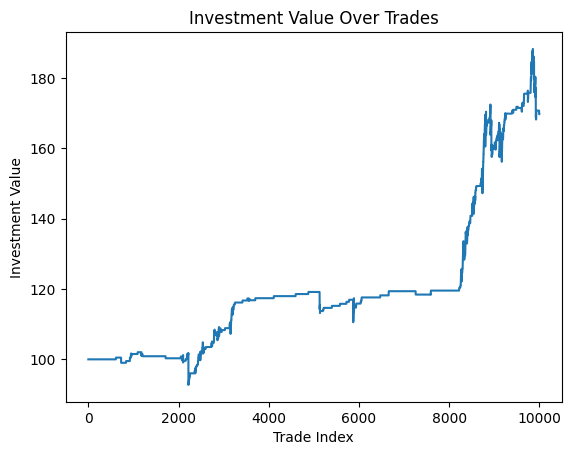

In [27]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset["LTCUSDT:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset["LTCUSDT:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
# Analysis of returns made by trading strategy

MINIMUM_PROBABILITY = 0.7
LEVERAGE = 5
GAIN = 0.5

CORRECT = 0
NUM_TRADES = 0
BAD_TRADES = []
ALL_TRADES = []
invested = 100
invested_list = []

for index, probbb in enumerate(validation_probabilities[1].to_list()):

    # IF THE PREDICTION HAS A SUFFICIENT PROBABILITY
    if probbb >= MINIMUM_PROBABILITY:
        NUM_TRADES += 1

        # IF THE PREDICTION IS CORRECT
        if validation_predictions["Label"][index] == validation_dataset["Label"][index]:
            CORRECT += 1
            ALL_TRADES.append(GAIN * LEVERAGE)
            invested *= 1 + (GAIN / 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

        # IF THE PREDICTION IS INCORRECT    
        else:
            true_close = validation_dataset["LTCUSDT:close4"][index + 1]
            bad_trad = (round(true_close * LEVERAGE, 3), round(probbb, 3))
            BAD_TRADES.append(bad_trad)
            ALL_TRADES.append(true_close * LEVERAGE)
            invested *= 1 + (true_close/ 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

    else:
        copyy = invested
        invested_list.append(copyy)



print(f"CORRECT: {CORRECT}")
print(f"WRONG: {NUM_TRADES - CORRECT}")
print(f"NUMBER OF TRADES: {NUM_TRADES}")
print(f"WINRATE: {round(CORRECT / NUM_TRADES, 3) * 100}%")
print(f"RETURN: {invested - 100}")
print(f"IVESTMENT VALUE: {invested}")
print("----------------------------------")
for btbb in BAD_TRADES:
    print(btbb)


from matplotlib import pyplot as plt

plt.plot(invested_list)
plt.show()




In [ ]:
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.7
LEVERAGE = 5

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2["LTCUSDT:high4"][index + 1]
        true_low = test_data_frame2["LTCUSDT:low4"][index + 1]
        true_close = test_data_frame2["LTCUSDT:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")